Yahoo fin S&P 500 scraping

Then, in the directory of the project run `python src/yahooscraper.py` to begin the scraping.

First implementation of the model

The model studied in the section 4. of the paper is defined as: $$ y^i_t = W^i_t \cdot \beta ^i _y + \gamma _y^i \cdot \delta ^i_t + \sqrt{\delta ^i_t} \cdot \exp(\frac{h^i_t} 2) \cdot \epsilon ^i_{y, t}$$ $$ h^i_{t+1} = \mu_h ^i + \phi_h ^i \cdot (h_t^i - \mu_h ^i)+ \sigma _h ^i \cdot \epsilon _{h,t} ^i $$
where $$ \epsilon ^i_{\cdot, t} \sim \mathcal N(0,1)$$ $$\delta ^i _t \sim \text{Inv-Gamma}(\frac{\nu_y ^i} 2, \frac{\nu_y ^i} 2)$$ $$W^i _t = (1, y^i_{t-1}, \dots, y^i_{t-k}) $$ with $k=3, 5$ depending on the type of the series studied ($3$ for equities series and $5$ for credit default swap series). We assume moreover that $$\text{Corr}(\epsilon ^i_{y, t}, \epsilon ^i_{h, t}) = \rho^i$$

The different indices respectively are:
1. $i$: the index of the time series.
2. $t$: the date of observation of the stochastic process.
3. $h$ and $y$: if whether the variable is associated to the state $h$ or the observation $y$.

**Remarks on the model**: 
- The observations are $y^i_t$ which is the log-return of the $i$-th observed time series at time $t$.
- The state variable is $h^i_t$ which is associated to the observation $y^i_t$.
- The article models the logreturns as SV (Stochastic Volatility) processes, $h$ can be associated with the volatility associated to $\exp(y^i_\cdot)$.

The priors of the parameters are:
- $\mu_h^i \sim \mathcal N(0.4, 2)$
- $\phi _h ^i \sim \mathcal N(0.985, 0.001)$
- $(\sigma ^i _h )^2 \sim \text{Inv Gamma}(20, 0.25)$

## Model Simulation

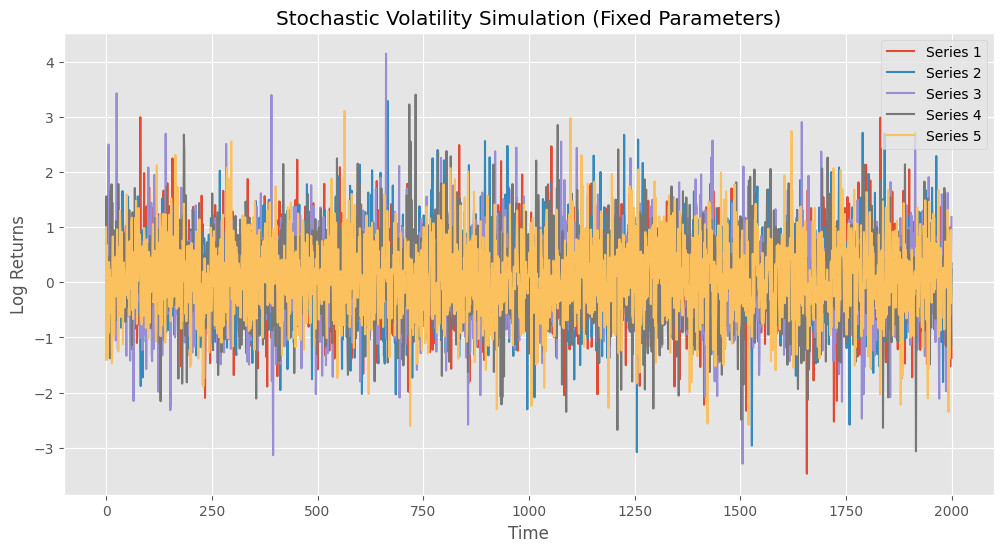

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, norm

np.random.seed(42)

n_series = 200
T = 2000
n_covariates = 6

# 1) Choose fixed or near-fixed parameters
mu_h_value = -1.0
phi_h_value = 0.9
sigma_h_value = 0.1
rho_value = 0.2
nu_y_value = 8.0
beta_y_value = 0.0
gamma_y_value = 0.05

# 2) Build arrays with fixed parameters
mu_h = np.full(n_series, mu_h_value)
phi_h = np.full(n_series, phi_h_value)
sigma_h = np.full(n_series, sigma_h_value)
rho = np.full(n_series, rho_value)
nu_y = np.full(n_series, nu_y_value)
beta_y = np.full((n_series, n_covariates), beta_y_value)
gamma_y = np.full(n_series, gamma_y_value)

# 3) Allocate simulation arrays
y = np.ones((n_series, T))
h = np.zeros((n_series, T))
W = np.ones((n_series, T, n_covariates))

# 4) Simulate each series
for i in range(n_series):
    # Initialize h[i,0]
    h[i,0] = mu_h[i]  # or some small noise around mu_h[i]

    for t in range(1,T):
        # Covariates
        for lag in range(n_covariates):
            if t - lag >= 0:
                W[i,t,lag] = y[i,t-lag]
            else:
                W[i,t,lag] = 0
        W[i,t,0] = 1.0  # intercept

        # Evolve latent volatility
        eps_h = np.random.normal()
        h[i,t] = (mu_h[i] 
                  + phi_h[i]*(h[i,t-1] - mu_h[i]) 
                  + sigma_h[i]*eps_h)
        
        # Inv-Gamma
        delta = invgamma.rvs(nu_y[i]/2, scale=nu_y[i]/2)

        # Leverage effect
        eps_y_ind = np.random.normal()
        eps_y = rho[i]*eps_h + np.sqrt(1 - rho[i]**2)*eps_y_ind

        # Mean
        mean_y = np.dot(W[i,t], beta_y[i])
        # Final log return
        y[i,t] = (mean_y 
                  + gamma_y[i]*delta 
                  + np.sqrt(delta)*np.exp(0.5*h[i,t])*eps_y)

# 5) Plot a few series
plt.figure(figsize=(12,6))
for i in range(5):
    plt.plot(y[i], label=f'Series {i+1}')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Stochastic Volatility Simulation (Fixed Parameters)')
plt.legend()
plt.show()

**Remark:** one can observe that does simulated data are quite different from real financial time series. It seems they have different scale and they don't have those characteristic 'jumps' that appear a lot for this kind of time series.

## Bootstrap Filter

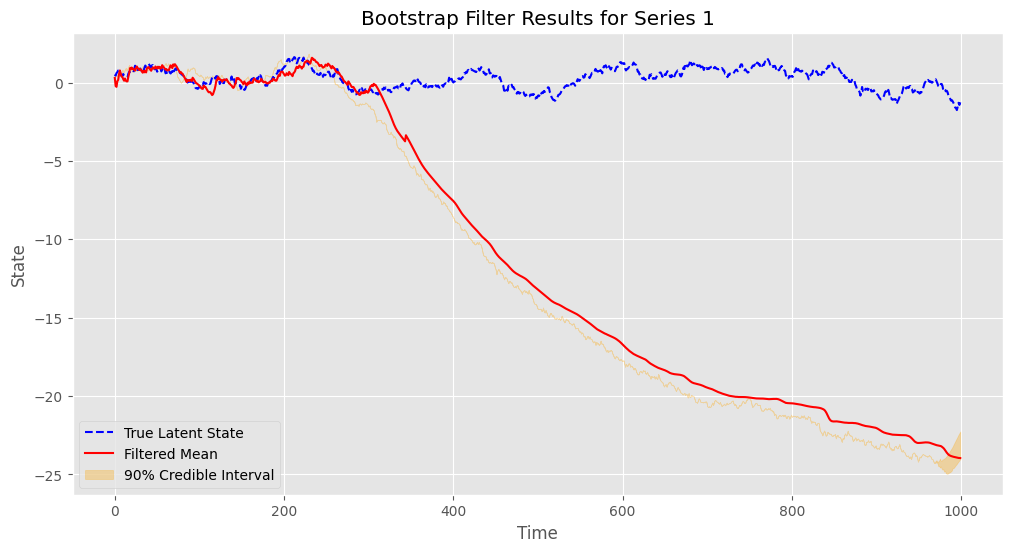

Bootstrap filtering and plotting completed.


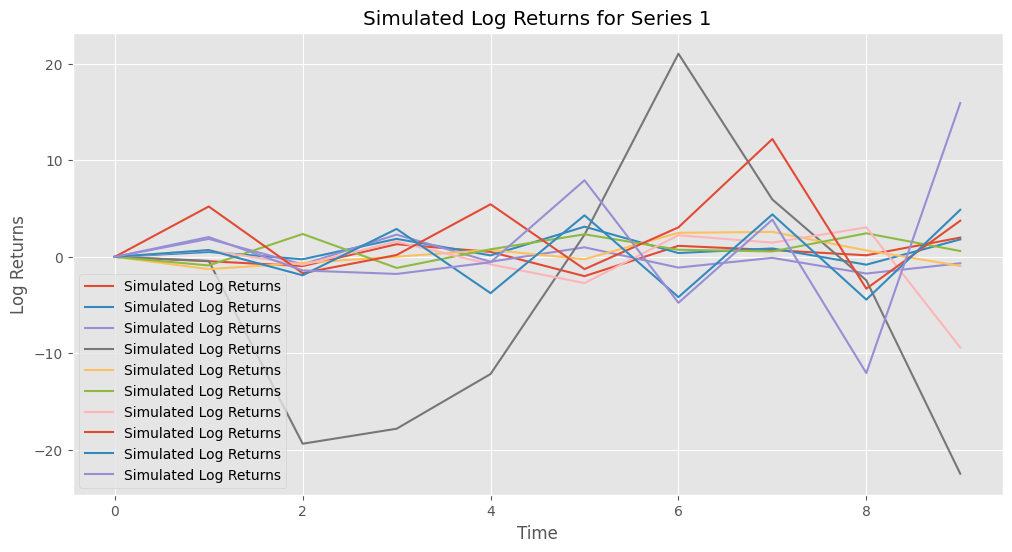

Simulation of log returns plotted.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, t, norm

# -------------------------
# Model Parameters
# -------------------------
np.random.seed(42)

# Dimensions and Hyperparameters
n_series = 200   # Number of series
T = 1000 # Time steps
N = 10000 # Number of particles
ESS_min = N / 10  # Effective sample size threshold

# Priors
mu_h = np.random.normal(0.4, np.sqrt(2), n_series)
phi_h = np.random.normal(0.985, np.sqrt(0.001), n_series)
phi_h = np.clip(phi_h, 0, 0.999)  # Truncate to stationarity region
sigma_h = np.sqrt(invgamma.rvs(20, scale=0.25, size=n_series))

gamma_y = np.random.normal(0, 0.1, n_series)
nu_y = 2 + np.random.gamma(2.5, 2, n_series)
rho = np.random.uniform(-0.9, 0.9, n_series)

# -------------------------
# Generate Data
# -------------------------
y = np.zeros((n_series, T))   # Observations
h = np.zeros((n_series, T))   # Latent states
W = np.ones((n_series, T, 6)) # Covariates (intercept + 5 lags)

# Simulate data and covariates
beta_y = np.random.normal(0, 0.5, (n_series, 6))  # Regression coefficients

for i in range(n_series):
    # Initialize state
    h[i, 0] = np.random.normal(mu_h[i], np.sqrt(sigma_h[i]))
    for time in range(1, T):
        # Update covariates (intercept + 5 lags)
        W[i, time, 0] = 1  # Intercept
        for lag in range(1, 6):
            W[i, time, lag] = y[i, time - lag] if time - lag >= 0 else 0

        # Evolve latent volatility
        h[i, time] = mu_h[i] + phi_h[i] * (h[i, time - 1] - mu_h[i]) + sigma_h[i] * np.random.normal(0, 1)
        
        # Mixing variable (δ)
        delta = invgamma.rvs(nu_y[i] / 2, scale=nu_y[i] / 2)

        # Leverage effect
        eps_h = np.random.normal(0, 1)
        eps_y = rho[i] * eps_h + np.sqrt(1 - rho[i] ** 2) * np.random.normal(0, 1)

        # Simulate observations (conditional mean based on covariates)
        mean_y = W[i, time] @ beta_y[i]
        y[i, time] = mean_y + gamma_y[i] * delta + np.sqrt(delta) * np.exp(h[i, time] / 2) * eps_y

# -------------------------
# Bootstrap Filter
# -------------------------
def bootstrap_filter(y, W, n_particles, T, plot_index=0):
    # Initialize particles and weights
    particles = np.zeros((n_particles, T))
    weights = np.ones(n_particles) / n_particles
    filtered_means = np.zeros(T)
    
    # Sample initial particles
    particles[:, 0] = np.random.normal(mu_h[plot_index], np.sqrt(sigma_h[plot_index] * 100), n_particles)
    weights *= t.pdf(y[0], df=nu_y[plot_index], loc=W[0] @ beta_y[plot_index], scale=np.exp(particles[:, 0] / 2))
    weights /= np.sum(weights)

    filtered_means[0] = np.sum(particles[:, 0] * weights)

    for time in range(1, T):
        # Compute Effective Sample Size (ESS)
        ESS = 1 / np.sum(weights ** 2)

        # Resampling step if ESS is below threshold
        if ESS < ESS_min:
            indices = np.random.choice(n_particles, size=n_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(n_particles) / n_particles

        # Propagation step
        particles[:, time] = mu_h[plot_index] + phi_h[plot_index] * (particles[:, time - 1] - mu_h[plot_index]) + sigma_h[plot_index] * np.random.normal(0, 1, n_particles)

        # Update weights using likelihood
        mean_y = W[time] @ beta_y[plot_index]  # Conditional mean using covariates
        scale = np.exp(particles[:, time] / 2)
        likelihoods = t.pdf(y[time], df=nu_y[plot_index], loc=mean_y, scale=scale)
        weights *= likelihoods
        weights /= np.sum(weights)

        # Compute filtered mean
        filtered_means[time] = np.sum(particles[:, time] * weights)

    return filtered_means, particles

# -------------------------
# Run Filter and Plot Results
# -------------------------
plot_index = 0  # Choose the series to plot
filtered_means, particles = bootstrap_filter(y[plot_index], W[plot_index], N, T, plot_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(T), h[plot_index], label='True Latent State', color='blue', linestyle='--')
plt.plot(range(T), filtered_means, label='Filtered Mean', color='red')
plt.fill_between(range(T), np.percentile(particles, 5, axis=0), np.percentile(particles, 95, axis=0), color='orange', alpha=0.3, label='90% Credible Interval')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Bootstrap Filter Results for Series {}'.format(plot_index + 1))
plt.legend()
plt.grid(True)
plt.show()

print("Bootstrap filtering and plotting completed.")
plt.figure(figsize=(12, 6))
for k in range(10):
    plt.plot(y[k, :10], label='Simulated Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Simulated Log Returns for Series {}'.format(plot_index + 1))
plt.legend()
plt.grid(True)
plt.show()

print("Simulation of log returns plotted.")

## Tests on Real Data

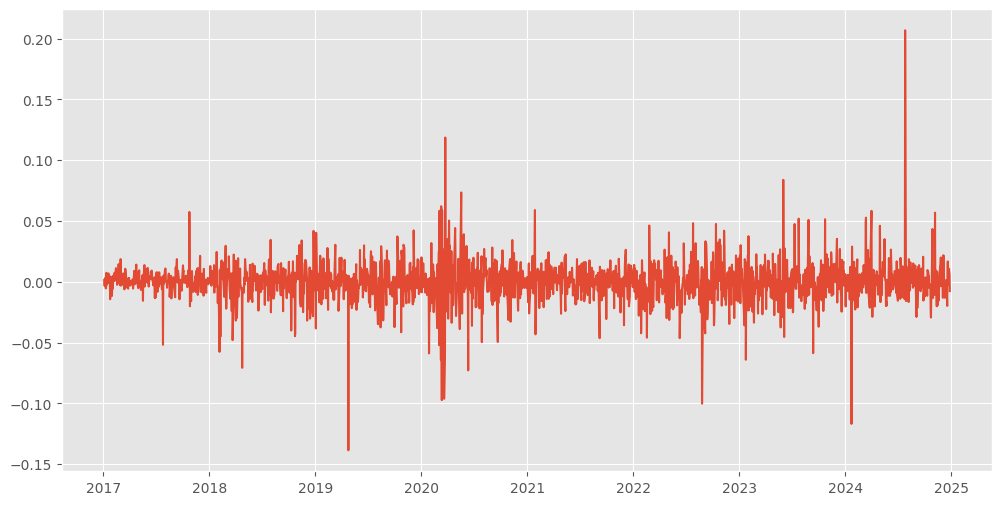

In [15]:
import pandas as pd

prices = pd.read_csv('data/sp500_prices.csv')
prices['Date'] = pd.to_datetime(prices['Date'])

company = prices['Company'].drop_duplicates().values[0]
ex_prices = prices[prices['Company'] == company][['Date', 'Close']]

price = ex_prices['Close'].values
logreturns = np.log(price[1:]/ price[:-1])
dates = ex_prices['Date'].values[1:]

plt.figure(figsize=(12,6))
plt.plot(dates, logreturns)
plt.show()

Loaded data for company: 3M
Number of log returns: 2009
Shape of W_full: (2004, 6), shape of y_data: (2004,)


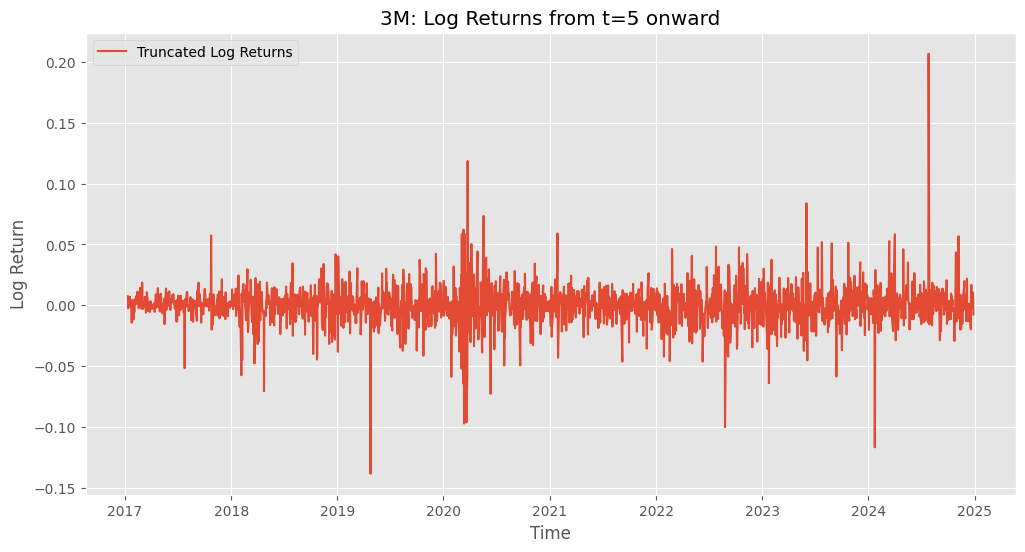

Optimization Results:
beta_y: [1.00000012 1.00000045 1.00000053 1.00000019 1.00000085 1.00000048]
gamma_y: 0.10000033387712325
phi_h: 0.9500005165463069
mu_h: -0.9999999802108296
sigma_h: 0.09999981465728586
rho: 4.848757280308389e-07
nu_y: 3.0000003299230085
log_likelihood: -4181.268372351316


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t, invgamma, norm


# -------------------------
# 1. LOAD DATA
# -------------------------
def load_data(csv_path='data/sp500_prices.csv'):
    """
    Load a CSV with columns ['Date', 'Company', 'Close'], 
    then select a single company and compute log returns.
    """
    prices = pd.read_csv(csv_path)
    prices['Date'] = pd.to_datetime(prices['Date'])
    
    # Extract a single company
    company = prices['Company'].unique()[0]
    df_company = prices[prices['Company'] == company].copy()
    df_company.sort_values('Date', inplace=True)
    
    # Compute log returns
    price_vals = df_company['Close'].values
    dates = df_company['Date'].values
    # log return from t-1 to t
    logreturns = np.log(price_vals[1:] / price_vals[:-1])
    dates = dates[1:]
    
    return company, dates, logreturns


# -------------------------
# 2. BUILD COVARIATES (NO ZERO PADDING)
# -------------------------
def build_covariates(y, n_lags=5):
    """
    Build covariate matrix W with shape ((T - n_lags) x (n_lags+1)).
    Each row t has [1, y_{t-1}, ..., y_{t-5}] for t >= n_lags.
    We effectively 'skip' the first n_lags data points.
    """
    T = len(y)
    # We'll have (T - n_lags) valid rows
    W = np.zeros((T - n_lags, n_lags + 1))

    # For each t in [n_lags, ..., T-1]
    for t in range(n_lags, T):
        row_idx = t - n_lags
        # Intercept
        W[row_idx, 0] = 1.0
        # Lags
        for lag in range(1, n_lags + 1):
            W[row_idx, lag] = y[t - lag]
    
    return W


def log_likelihood(params, y_data, W_data):
    """
    Negative log-likelihood for a simplified SV model with:
      - h_t ~ AR(1)
      - delta ~ Inv-Gamma
      - Student's t distribution for y_t with df=nu_y
      - leverage parameter rho
    y_data: shape (T,)
    W_data: shape (T, 6) -> [1, y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-5}]
    """
    T = len(y_data)  # This is T' = original T - n_lags

    # Unpack parameters
    beta_y = params[:6]      # 6 regression coefficients
    gamma_y = params[6]      # skew param
    phi_h = params[7]        # AR(1) persistence
    mu_h = params[8]         # long-run mean
    sigma_h = params[9]      # volatility of volatility
    rho = params[10]         # leverage
    nu_y = params[11]        # degrees of freedom

    # Constraints
    sigma_h = max(sigma_h, 1e-6)
    phi_h = np.clip(phi_h, 0, 0.999)
    nu_y = max(nu_y, 2.1)

    # Initialize latent volatility
    # We'll treat h[0] as mu_h or a small random offset:
    h = np.zeros(T)
    h[0] = mu_h  # or mu_h + small noise

    log_like_sum = 0.0

    for time in range(1, T):
        # AR(1) update for h[t]
        # (In rigorous MLE, we'd handle the noise in h[t] carefully, 
        #  but let's do a demonstration approach.)
        h[time] = mu_h + phi_h*(h[time-1] - mu_h)
        # Optionally add random draw:
        # h[t] += sigma_h * np.random.normal(0, 1)

        # Inverse Gamma mixing
        delta = invgamma.rvs(nu_y/2, scale=nu_y/2)

        # Leverage
        eps_h = np.random.normal(0, 1)
        eps_y = rho*eps_h + np.sqrt(1 - rho**2)*np.random.normal(0, 1)

        # Regression mean
        mean_y = W_data[time] @ beta_y
        # scale
        scale = np.sqrt(delta) * np.exp(h[time]/2)
        # location shift from gamma_y * delta
        loc = mean_y + gamma_y * delta

        ll_point = t.logpdf(y_data[time], df=nu_y, loc=loc, scale=scale)
        log_like_sum += ll_point

    return -log_like_sum  # minimizer needs negative

def estimate_parameters(y_data, W_data, max_iter=10000, tol=1e-10):
    """
    Estimate the parameters by maximizing the log-likelihood 
    (or equivalently, minimizing the negative log-likelihood).
    """

    # Initial guesses
    beta_y_init = np.ones(6)  # [beta0, beta1, ..., beta5]
    gamma_y_init = 0.1
    phi_h_init = 0.95
    mu_h_init = -1.0
    sigma_h_init = 0.1
    rho_init = 0.0
    nu_y_init = 3.0

    initial_params = np.hstack([
        beta_y_init,
        gamma_y_init,
        phi_h_init,
        mu_h_init,
        sigma_h_init,
        rho_init,
        nu_y_init
    ])

    # Run optimizer
    result = minimize(
        fun=log_likelihood,
        x0=initial_params,
        args=(y_data, W_data),
        method='L-BFGS-B',
        options={'maxiter': max_iter, 'ftol': tol}
    )

    est_params = result.x
    est_dict = {
        'beta_y': est_params[:6],
        'gamma_y': est_params[6],
        'phi_h': est_params[7],
        'mu_h': est_params[8],
        'sigma_h': est_params[9],
        'rho': est_params[10],
        'nu_y': est_params[11],
        'log_likelihood': -result.fun  # since fun is negative log-likelihood
    }
    return est_dict



company, dates, logreturns = load_data('data/sp500_prices.csv')
print("Loaded data for company:", company)
print("Number of log returns:", len(logreturns))

n_lags = 5
W_full = build_covariates(logreturns, n_lags=n_lags)  
y_data = logreturns[n_lags:]  # T' = T - 5

print(f"Shape of W_full: {W_full.shape}, shape of y_data: {y_data.shape}")

# Plot truncated log returns to confirm
# Notice that y_data[0] corresponds to original logreturns[5]
plt.figure(figsize=(12,6))
plt.plot(dates[n_lags:], y_data, label='Truncated Log Returns')
plt.title(f"{company}: Log Returns from t=5 onward")
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# 3) Estimate parameters
est_params = estimate_parameters(y_data, W_full)
print("Optimization Results:")
for k, v in est_params.items():
    print(f"{k}: {v}")

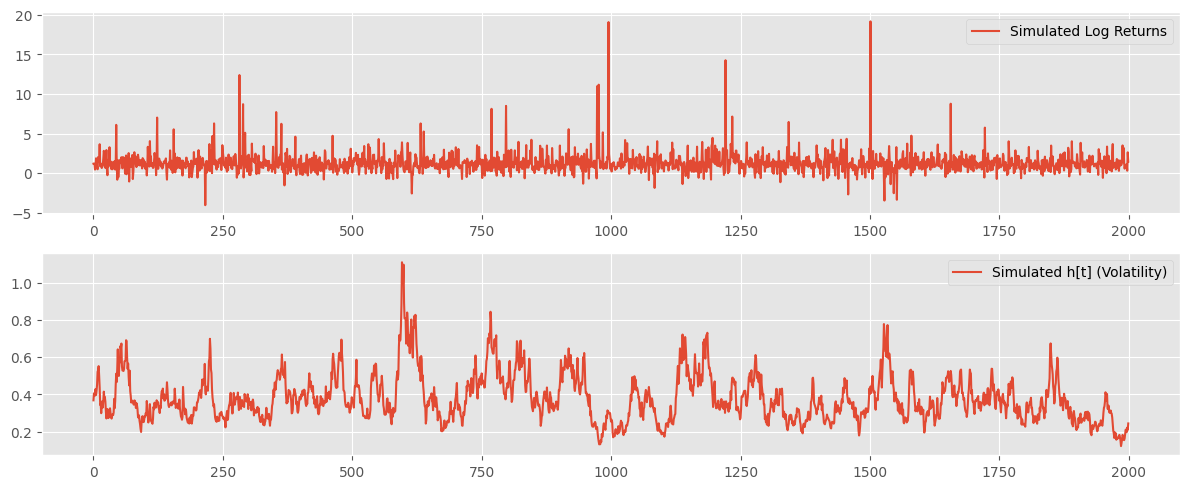

In [21]:
beta_y_opt = est_params['beta_y']    # array of length 6
gamma_y_opt = est_params['gamma_y']
phi_h_opt   = est_params['phi_h']
mu_h_opt    = est_params['mu_h']
sigma_h_opt = est_params['sigma_h']
rho_opt     = est_params['rho']
nu_y_opt    = est_params['nu_y']

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma

def simulate_from_model(T_sim,
                        beta_y, gamma_y,
                        phi_h, mu_h, sigma_h,
                        rho, nu_y,
                        W_sim=None,  # covariates
                        h_init=None):
    """
    Simulate a time series (y[t], h[t]) for t in 0..(T_sim-1) using
    the SV model with leveraged normal errors and inverse-gamma mixing.

    Parameters
    ----------
    T_sim : int
        Number of time steps to simulate.
    beta_y : array-like of length 6
        Regression coefficients for W[t].
    gamma_y : float
        Skew parameter for delta.
    phi_h : float
        Persistence of volatility.
    mu_h : float
        Long-run mean of volatility.
    sigma_h : float
        Volatility of volatility (state noise).
    rho : float
        Leverage parameter (corr between eps_h and eps_y).
    nu_y : float
        Degrees of freedom (inverse gamma).
    W_sim : np.ndarray or None
        Covariate matrix for times t=0..(T_sim-1), shape=(T_sim, 6).
        If None, we build a trivial matrix with an intercept only.
    h_init : float or None
        Initial state for h[0]. If None, default to mu_h.

    Returns
    -------
    y_sim : np.ndarray of shape (T_sim,)
        Simulated log returns.
    h_sim : np.ndarray of shape (T_sim,)
        Simulated latent volatility.
    """
    # Prepare arrays
    y_sim = np.zeros(T_sim)
    h_sim = np.zeros(T_sim)

    # If not provided, build a simple W with [1, 0, 0, 0, 0, 0] (just intercept)
    if W_sim is None:
        W_sim = np.zeros((T_sim, 6))
        W_sim[:, 0] = 1.0

    # Initialize h
    if h_init is None:
        h_sim[0] = mu_h
    else:
        h_sim[0] = h_init

    for t in range(T_sim):
        # For t=0, we skip the update, just use initial h[0].
        if t > 0:
            # Evolve latent volatility
            eps_h = np.random.normal(0,1)
            h_sim[t] = (mu_h
                        + phi_h*(h_sim[t-1] - mu_h)
                        + sigma_h*eps_h)

        # Mixing variable
        delta = invgamma.rvs(nu_y/2, scale=nu_y/2)

        # Correlated error
        eps_h_draw = np.random.normal(0,1)
        eps_y_draw = rho*eps_h_draw + np.sqrt(1-rho**2)*np.random.normal(0,1)

        # Mean from covariates
        mean_y = np.dot(W_sim[t], beta_y)

        # Final log return
        y_sim[t] = (mean_y
                    + gamma_y*delta
                    + np.sqrt(delta)*np.exp(h_sim[t]/2)*eps_y_draw)

    return y_sim, h_sim


# Suppose you have run estimate_parameters and got 'est_params'.
# Unpack:
beta_y_opt   = est_params['beta_y']   # shape(6,)
gamma_y_opt  = est_params['gamma_y']
phi_h_opt    = est_params['phi_h']
mu_h_opt     = est_params['mu_h']
sigma_h_opt  = est_params['sigma_h']
rho_opt      = est_params['rho']
nu_y_opt     = est_params['nu_y']

# Decide how many steps to simulate
T_sim = 2000
# Optionally build a covariate matrix for simulation, e.g. intercept only:
W_sim = np.zeros((T_sim, 6))
W_sim[:, 0] = 1.0

y_sim, h_sim = simulate_from_model(T_sim,
                                    beta_y_opt, gamma_y_opt,
                                    phi_h_opt, mu_h_opt, sigma_h_opt,
                                    rho_opt, nu_y_opt,
                                    W_sim=W_sim,
                                    h_init=None)  # or h_init=mu_h_opt

# Plot the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(y_sim, label='Simulated Log Returns')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(np.exp(h_sim), label='Simulated h[t] (Volatility)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()